In [1]:
from __future__ import division

import os
import time
import sys
import random


import numpy as np
import matplotlib.pyplot as plt
import gc
from skimage.transform import resize
from IPython.display import clear_output
from collections import namedtuple, deque
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.layers import Layer, InputSpec, Conv2D, Conv2DTranspose, Activation, Input, UpSampling2D, Dropout, Concatenate, add
from tensorflow.keras import initializers, regularizers, constraints, Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import RandomNormal

from PIL import Image

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
class InstanceNormalization(Layer):
    """Instance normalization layer.
    Normalize the activations of the previous layer at each step,
    i.e. applies a transformation that maintains the mean activation
    close to 0 and the activation standard deviation close to 1.
    # Arguments
        axis: Integer, the axis that should be normalized
            (typically the features axis).
            For instance, after a `Conv2D` layer with
            `data_format="channels_first"`,
            set `axis=1` in `InstanceNormalization`.
            Setting `axis=None` will normalize all values in each
            instance of the batch.
            Axis 0 is the batch dimension. `axis` cannot be set to 0 to avoid errors.
        epsilon: Small float added to variance to avoid dividing by zero.
        center: If True, add offset of `beta` to normalized tensor.
            If False, `beta` is ignored.
        scale: If True, multiply by `gamma`.
            If False, `gamma` is not used.
            When the next layer is linear (also e.g. `nn.relu`),
            this can be disabled since the scaling
            will be done by the next layer.
        beta_initializer: Initializer for the beta weight.
        gamma_initializer: Initializer for the gamma weight.
        beta_regularizer: Optional regularizer for the beta weight.
        gamma_regularizer: Optional regularizer for the gamma weight.
        beta_constraint: Optional constraint for the beta weight.
        gamma_constraint: Optional constraint for the gamma weight.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a Sequential model.
    # Output shape
        Same shape as input.
    # References
        - [Layer Normalization](https://arxiv.org/abs/1607.06450)
        - [Instance Normalization: The Missing Ingredient for Fast Stylization](
        https://arxiv.org/abs/1607.08022)
    """
    def __init__(self,
                 axis=None,
                 epsilon=1e-3,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.axis = axis
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)

    def build(self, input_shape):
        ndim = len(input_shape)
        if self.axis == 0:
            raise ValueError('Axis cannot be zero')

        if (self.axis is not None) and (ndim == 2):
            raise ValueError('Cannot specify axis for rank 1 tensor')

        self.input_spec = InputSpec(ndim=ndim)

        if self.axis is None:
            shape = (1,)
        else:
            shape = (input_shape[self.axis],)

        if self.scale:
            self.gamma = self.add_weight(shape=shape,
                                         name='gamma',
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,
                                        name='beta',
                                        initializer=self.beta_initializer,
                                        regularizer=self.beta_regularizer,
                                        constraint=self.beta_constraint)
        else:
            self.beta = None
        self.built = True

    def call(self, inputs, training=None):
        input_shape = K.int_shape(inputs)
        reduction_axes = list(range(0, len(input_shape)))

        if self.axis is not None:
            del reduction_axes[self.axis]

        del reduction_axes[0]

        mean = K.mean(inputs, reduction_axes, keepdims=True)
        stddev = K.std(inputs, reduction_axes, keepdims=True) + self.epsilon
        normed = (inputs - mean) / stddev

        broadcast_shape = [1] * len(input_shape)
        if self.axis is not None:
            broadcast_shape[self.axis] = input_shape[self.axis]

        if self.scale:
            broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
            normed = normed * broadcast_gamma
        if self.center:
            broadcast_beta = K.reshape(self.beta, broadcast_shape)
            normed = normed + broadcast_beta
        return normed

    def get_config(self):
        config = {
            'axis': self.axis,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'gamma_initializer': initializers.serialize(self.gamma_initializer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'gamma_constraint': constraints.serialize(self.gamma_constraint)
        }
        base_config = super(InstanceNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [4]:
class ImageBuffer:
    """Fixed-size buffer to store image tuples."""

    def __init__(self, buffer_size):
        """Initialize a ImageBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
        """
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.images = namedtuple("Images", field_names=['real_image_X', 'fake_image_X', 
                                                        'real_image_Y', 'fake_image_Y'])
    
    def add(self, real_image_X, fake_image_X, real_image_Y, fake_image_Y):
        """Add a new images to memory."""
        image_pair = self.images(real_image_X, fake_image_X, real_image_Y, fake_image_Y)
        self.memory.append(image_pair)
    
    def sample(self):
        """Return a batch of image tuples from memory."""
        return self.memory.popleft()

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [5]:
class ReflectionPadding2D(tf.keras.layers.Layer):
    '''
        From: https://stackoverflow.com/questions/50677544/reflection-padding-conv2d
        jeevaa_v's answer
    '''
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        '''If you are using "channels_last" configuration'''
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')

class ConvBlock(tf.keras.Model):
    def __init__(self, filters, kernel_size=7, strides=1, padding='valid', activation=tf.nn.relu):
        super(ConvBlock, self).__init__(name='')
        self.blocks = Sequential([Conv2D(filters, kernel_size, strides, padding=padding, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)),
                                        InstanceNormalization(axis=-1, epsilon=1e-5, center=False, scale=False),
                                        Activation(activation)])
    
    def call(self, input_tensor):
        x = self.blocks(input_tensor)
        return x

class DeConvBlock(tf.keras.Model):
    def __init__(self, filters, kernel_size=7, strides=1, padding='valid', activation=tf.nn.relu):
        super(DeConvBlock, self).__init__(name='')
        self.blocks = Sequential([Conv2DTranspose(filters, kernel_size, strides, padding=padding, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)),
                                    InstanceNormalization(axis=-1, epsilon=1e-5, center=False, scale=False),
                                    Activation(activation)])
    
    def call(self, input_tensor):
        x = self.blocks(input_tensor)
        return x
    
class ResidualBlock(tf.keras.Model):
    def __init__(self, filters, kernel_size=3, strides=1, padding='valid', activation=tf.nn.relu):
        super(ResidualBlock, self).__init__(name='')
        self.conv_blocks = Sequential([Conv2D(filters, kernel_size, strides, padding=padding, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)),
                                            ReflectionPadding2D((1, 1)),
                                            InstanceNormalization(axis=-1, epsilon=1e-5, center=False, scale=False),
                                            Activation(activation),
                                            Conv2D(filters, kernel_size, strides, padding=padding, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)),
                                            ReflectionPadding2D((1, 1)),
                                            InstanceNormalization(axis=-1, epsilon=1e-5, center=False, scale=False)])
    
    def call(self, input_tensor):
        x = self.conv_blocks(input_tensor)
        x = add([x, input_tensor])
        return x
    
def create_cyclegan_generator(input_shape, n_blocks=9, name=''):
    input_tensor = Input(input_shape)
    x = ReflectionPadding2D((3, 3))(input_tensor)
    x = ConvBlock(filters=64, kernel_size=7, strides=1, activation=tf.nn.leaky_relu)(x)
    x = ConvBlock(filters=128, kernel_size=3, strides=2, padding='same', activation=tf.nn.leaky_relu)(x)
    x = ConvBlock(filters=256, kernel_size=3, strides=2, padding='same', activation=tf.nn.leaky_relu)(x)
    
    for i in range(n_blocks):
        x = ResidualBlock(256, kernel_size=3, strides=1, activation=tf.nn.leaky_relu)(x)
    
    x = DeConvBlock(filters=128, kernel_size=3, strides=2, padding='same', activation=tf.nn.leaky_relu)(x)
    x = DeConvBlock(filters=64, kernel_size=3, strides=2, padding='same', activation=tf.nn.leaky_relu)(x)
    
    x = ReflectionPadding2D((3, 3))(x)
    x = Conv2D(filters=3, kernel_size=7, strides=1, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    
    if len(name) > 0:
        output = Activation('tanh', name='{}_output'.format(name))(x)
        model = Model(inputs=input_tensor, outputs=output, name=name)
    else:
        output = Activation('tanh')(x)
        model = Model(inputs=input_tensor, outputs=output)
    
    return model

def create_cyclegan_discriminator(input_shape, name=''):
    input_tensor = Input(input_shape)
    x = Conv2D(filters=64, kernel_size=4, strides=2, padding='valid',
               kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(input_tensor)
    x = Activation(tf.nn.leaky_relu)(x)
    
    x = ConvBlock(filters=128, kernel_size=4, strides=2, padding='valid', activation=tf.nn.leaky_relu)(x)
    x = ConvBlock(filters=256, kernel_size=4, strides=2, padding='valid', activation=tf.nn.leaky_relu)(x)
    x = ConvBlock(filters=512, kernel_size=4, strides=1, padding='same', activation=tf.nn.leaky_relu)(x)
    
    if len(name) > 0:
        output = Conv2D(filters=1, kernel_size=4, strides=1, padding='same',
                        kernel_initializer=RandomNormal(mean=0.0, stddev=0.02)
                        , name='{}_output'.format(name))(x)
        model = Model(inputs=input_tensor, outputs=output, name=name)
    else:
        output = Conv2D(filters=1, kernel_size=4, strides=1, padding='same',
                        kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
        model = Model(inputs=input_tensor, outputs=output)
    
    return model

In [6]:
INPUT_SHAPE = (None, None, 3)
DATASET = 'monet2photo'

CURRENT_EPOCH = 1
SAVE_EVERY_N_EPOCH = 5

In [7]:
G_XtoY = create_cyclegan_generator(INPUT_SHAPE, n_blocks=5, name='G_XtoY')
G_YtoX = create_cyclegan_generator(INPUT_SHAPE, n_blocks=5, name='G_YtoX')

In [8]:
G_XtoY.summary()

Model: "G_XtoY"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
reflection_padding2d (Reflec (None, None, None, 3)     0         
_________________________________________________________________
conv_block (ConvBlock)       (None, None, None, 64)    9472      
_________________________________________________________________
conv_block_1 (ConvBlock)     (None, None, None, 128)   73856     
_________________________________________________________________
conv_block_2 (ConvBlock)     (None, None, None, 256)   295168    
_________________________________________________________________
residual_block (ResidualBloc (None, None, None, 256)   1180160   
_________________________________________________________________
residual_block_1 (ResidualBl (None, None, None, 256)   11801

In [9]:
# https://www.tensorflow.org/tutorials/generative/cyclegan

# normalizing the images to [-1, 1]
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def read_test_image(path):
    img = np.array(Image.open(path))
    img = np.expand_dims(img, axis=0)
    img = normalize(img)
    return img

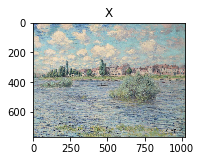

In [10]:
X_name = 'test_images/la_seine_a_lavacourt.jpg'
Y_name = 'test_images/Photo_by_Remi_Yuan_on_Unsplash.jpg'

sample_X = read_test_image(X_name)
sample_Y = read_test_image(Y_name)
plt.subplot(121)
plt.title('X')
plt.imshow(sample_X[0] * 0.5 + 0.5)

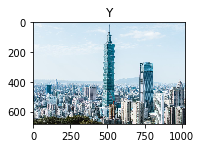

In [11]:
plt.subplot(121)
plt.title('Y')
plt.imshow(sample_Y[0] * 0.5 + 0.5)

In [12]:
checkpoint_path = os.path.join("checkpoints", DATASET)

ckpt = tf.train.Checkpoint(G_XtoY=G_XtoY,
                           G_YtoX=G_YtoX)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint).expect_partial()
    latest_epoch = int(ckpt_manager.latest_checkpoint.split('-')[1])
    CURRENT_EPOCH = latest_epoch * SAVE_EVERY_N_EPOCH
    print ('Latest checkpoint of epoch {} restored!!'.format(CURRENT_EPOCH))

Latest checkpoint of epoch 205 restored!!


In [13]:
pred1 = G_XtoY.predict_on_batch(sample_X)
pred1 = np.array(pred1[0] * 0.5 + 0.5)
plt.imsave('{}_predicted.jpg'.format(X_name), pred1)

In [14]:
pred2 = G_YtoX.predict_on_batch(sample_Y)
pred2 = np.array(pred2[0] * 0.5 + 0.5)
plt.imsave('{}_predicted.jpg'.format(Y_name), pred2)